In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
        
#Scaling and Splitting
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split

#Modeling
from sklearn.linear_model import LassoLars
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

#Evaluation
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

/kaggle/input/trailer-prices/trailerdata1.csv
/kaggle/input/trailer-prices/trailerdata2.csv


# About this notebook
This notebook aims to predict the price of a product (trailer) for an early stage start-up. The data has been anonymized. Due to the web infrastructure of manufacturers of similar trailers, the data was collected by hand. This project is still on-going and updated regularly. 

## Current Challenges
Currently the challenge is to deal with the small amount of data. There are unfortunately not many data points available in general, but work is underway to fill in vital details to increase the dataset as much as possible. 

In [2]:
#The trailer price data is saved in a csv file and must first be loaded
data = pd.read_csv('/kaggle/input/trailer-prices/trailerdata1.csv', sep=';')
data.head(5)

,Manufacturer,model,total dry weight,length,Cabin exterior width,exterior height,interior height,Usage Intent- On or Off Road,A/C,Roof Rack,...,Passenger Side Window,Rear Door,Rear Door Window,Wall Material,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Base price
0,Sunset Park RV,Sunray 109E,1660,198.0,102.0,84.0,54.0,On Road,Yes,Yes,...,Yes,No,No,Wood,Yes,Yes,Yes,Yes,Option,14879
1,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,90.0,54.0,On Road,Yes,Yes,...,Yes,No,No,Wood,Yes,Yes,Yes,Yes,Option,12500
2,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,90.0,54.0,On Road,Yes,Yes,...,Yes,No,No,Wood,Yes,Yes,Yes,Yes,Option,14997
3,Sunset Park RV,Sunray Classic 129,1930,185.0,102.0,105.0,73.0,On Road,Yes,Yes,...,Yes,No,No,Wood,Yes,Yes,Yes,Yes,Option,15965
4,Sunset Park RV,Classic 149,2260,188.0,102.0,108.0,74.0,On Road,Yes,Yes,...,Yes,No,No,Wood,Yes,Yes,Yes,Yes,No,18689


In [3]:
#inspect the data types of each column
#for modeling everything needs to be and int or float
data.dtypes

Manufacturer                     object
model                            object
total dry weight                  int64
length                          float64
Cabin exterior width            float64
exterior height                 float64
interior height                 float64
Usage Intent- On or Off Road     object
A/C                              object
Roof Rack                        object
Driver Side Window               object
Driver Side Door                 object
Driver Side Door Window          object
Passenger Side Door              object
Passenger Side Door Window       object
Passenger Side Window            object
Rear Door                        object
Rear Door Window                 object
Wall Material                    object
Spare Tire                       object
Battery Power Supply             object
Cabinets                         object
Refrigerator                     object
Awning                           object
Base price                        int64


In [4]:
#checking for missing values
#missing values must be dealt with for ML modeling
data.isna().sum()

Manufacturer                    0
model                           1
total dry weight                0
length                          0
Cabin exterior width            0
exterior height                 0
interior height                 0
Usage Intent- On or Off Road    0
A/C                             0
Roof Rack                       0
Driver Side Window              0
Driver Side Door                0
Driver Side Door Window         0
Passenger Side Door             0
Passenger Side Door Window      0
Passenger Side Window           0
Rear Door                       0
Rear Door Window                0
Wall Material                   0
Spare Tire                      0
Battery Power Supply            0
Cabinets                        0
Refrigerator                    0
Awning                          0
Base price                      0
dtype: int64

In [5]:
#drop columns which contain many empty values that are unlikely to be helpful in calculations
#data.drop(['model', 'year', 'sleeps', 'aluminum siding (inch)', 'A/C', 'msrp'], axis=1)

In [6]:
#83 is the target but it will be removed later to prevent problems later
#data2=data.drop(data.index[[83]])

In [7]:
data

,Manufacturer,model,total dry weight,length,Cabin exterior width,exterior height,interior height,Usage Intent- On or Off Road,A/C,Roof Rack,...,Passenger Side Window,Rear Door,Rear Door Window,Wall Material,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,Base price
0,Sunset Park RV,Sunray 109E,1660,198.0,102.0,84.0,54.0,On Road,Yes,Yes,...,Yes,No,No,Wood,Yes,Yes,Yes,Yes,Option,14879
1,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,90.0,54.0,On Road,Yes,Yes,...,Yes,No,No,Wood,Yes,Yes,Yes,Yes,Option,12500
2,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,90.0,54.0,On Road,Yes,Yes,...,Yes,No,No,Wood,Yes,Yes,Yes,Yes,Option,14997
3,Sunset Park RV,Sunray Classic 129,1930,185.0,102.0,105.0,73.0,On Road,Yes,Yes,...,Yes,No,No,Wood,Yes,Yes,Yes,Yes,Option,15965
4,Sunset Park RV,Classic 149,2260,188.0,102.0,108.0,74.0,On Road,Yes,Yes,...,Yes,No,No,Wood,Yes,Yes,Yes,Yes,No,18689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,MyMiniTrailer,Carpe Diem Mini,600,137.0,48.5,67.5,45.0,On Road,Option,Option,...,Base,No,Option,Wood,Option,No,No,No,Option,4995
87,MyMiniTrailer,Gypsy,900,137.0,60.5,67.5,45.0,On Road,Option,Option,...,Base,No,Option,Wood,Option,No,No,No,Option,6700
88,MyMiniTrailer,Serenity X,750,137.0,60.5,67.5,45.0,On Road,Option,Option,...,Base,No,Option,Wood,Option,No,No,No,Option,5900
89,MyMiniTrailer,Tranquility,1000,137.0,60.5,74.0,45.0,Off Road,Option,Option,...,Base,No,Option,Wood,Option,No,No,No,Option,9900


In [8]:
data.isna().sum()

Manufacturer                    0
model                           1
total dry weight                0
length                          0
Cabin exterior width            0
exterior height                 0
interior height                 0
Usage Intent- On or Off Road    0
A/C                             0
Roof Rack                       0
Driver Side Window              0
Driver Side Door                0
Driver Side Door Window         0
Passenger Side Door             0
Passenger Side Door Window      0
Passenger Side Window           0
Rear Door                       0
Rear Door Window                0
Wall Material                   0
Spare Tire                      0
Battery Power Supply            0
Cabinets                        0
Refrigerator                    0
Awning                          0
Base price                      0
dtype: int64

In [9]:
data.shape

(91, 25)

In [10]:
#data=data.drop(data.index[[78]])

In [11]:
#these columns will be renamed to remove the space in the heading 
data = data.rename(columns={"exterior height": "eheight", "total dry weight": "tdweight", "interior height":"intheight", "exterior width":"ewidth", "Base price":"price"})

In [12]:
#data2['intheight'] = data2['intheight'].fillna(data2['intheight'].mean())
#data2['ewidth'] = data2['ewidth'].fillna(data2['ewidth'].mean())

In [13]:
data.isna().sum()

Manufacturer                    0
model                           1
tdweight                        0
length                          0
Cabin exterior width            0
eheight                         0
intheight                       0
Usage Intent- On or Off Road    0
A/C                             0
Roof Rack                       0
Driver Side Window              0
Driver Side Door                0
Driver Side Door Window         0
Passenger Side Door             0
Passenger Side Door Window      0
Passenger Side Window           0
Rear Door                       0
Rear Door Window                0
Wall Material                   0
Spare Tire                      0
Battery Power Supply            0
Cabinets                        0
Refrigerator                    0
Awning                          0
price                           0
dtype: int64

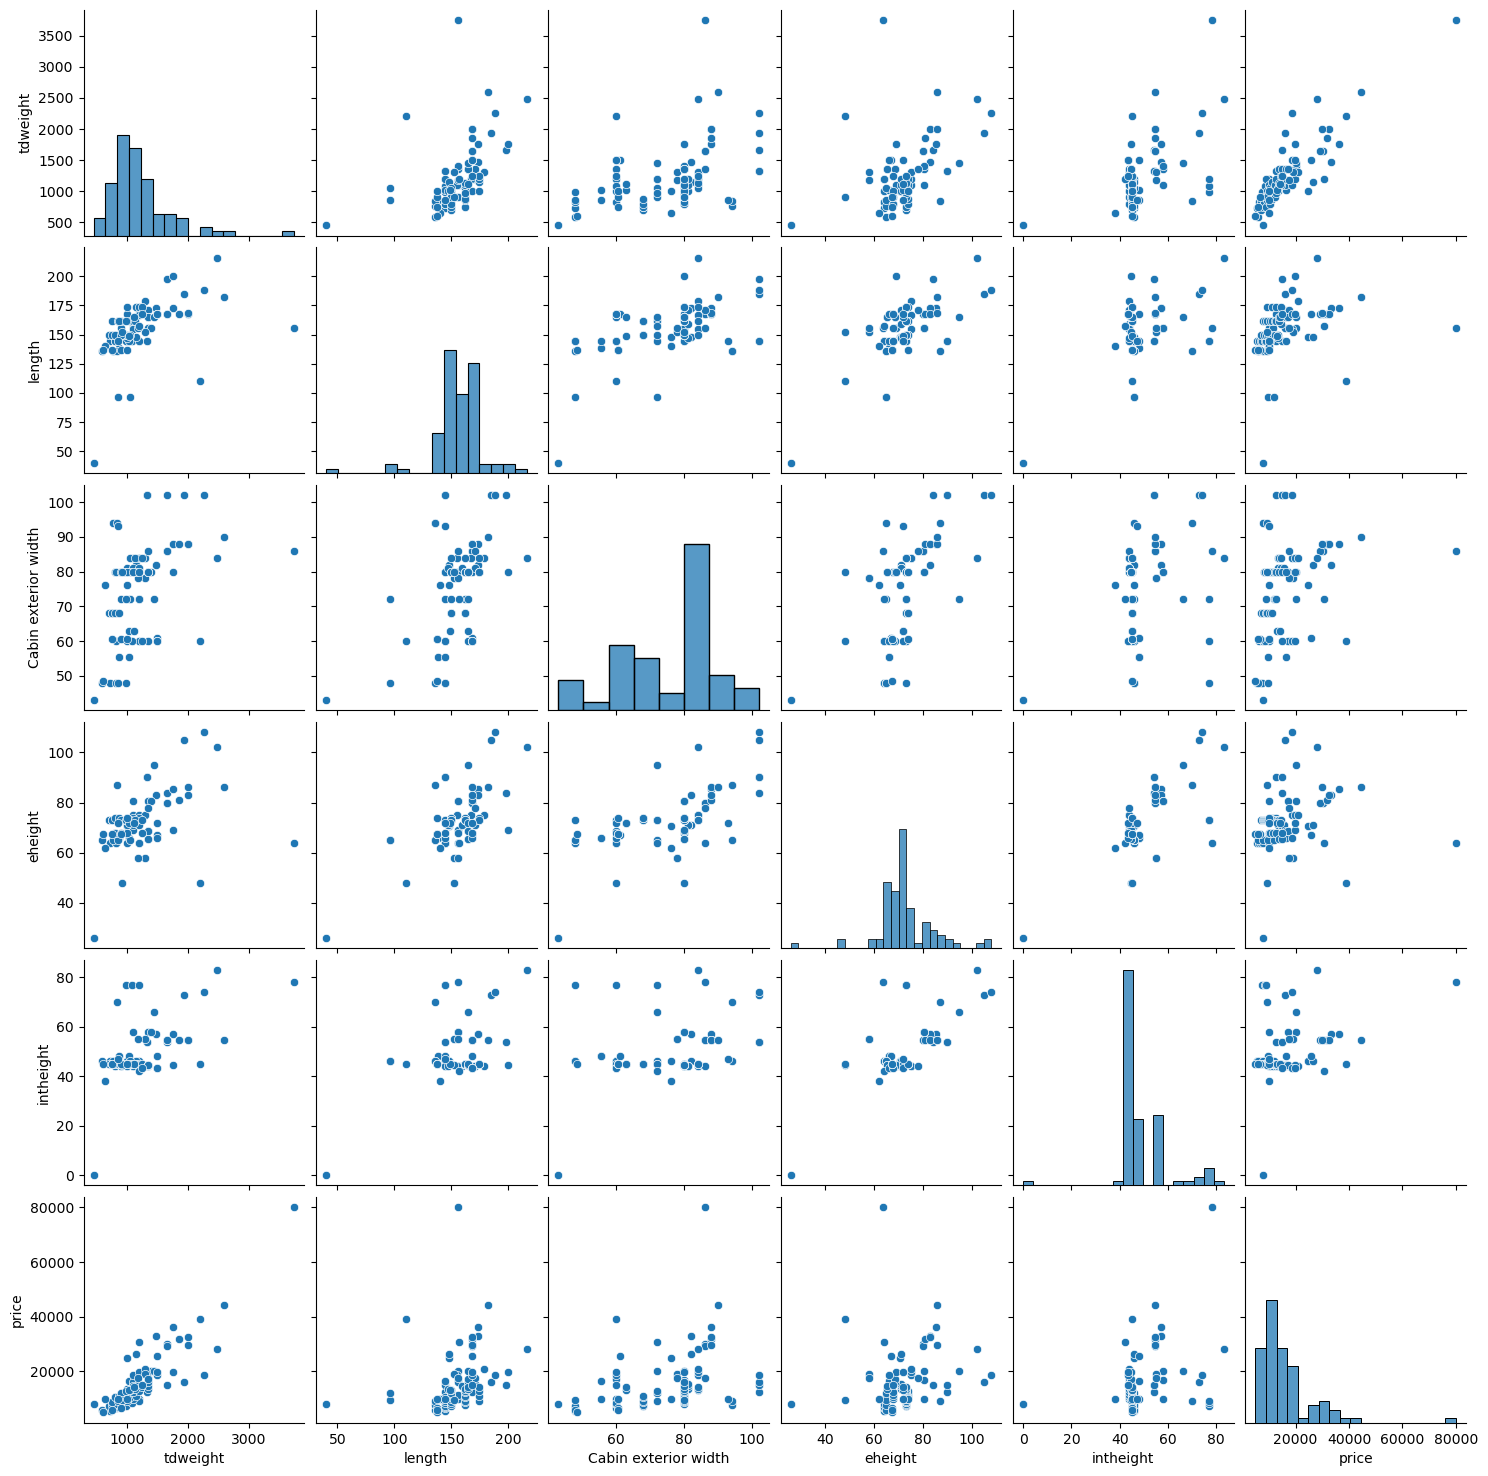

In [14]:
sns.pairplot(data)

Of all the variables, total dry weight appears to be the most correlated with the price. Let's look at it a bit more closely. 

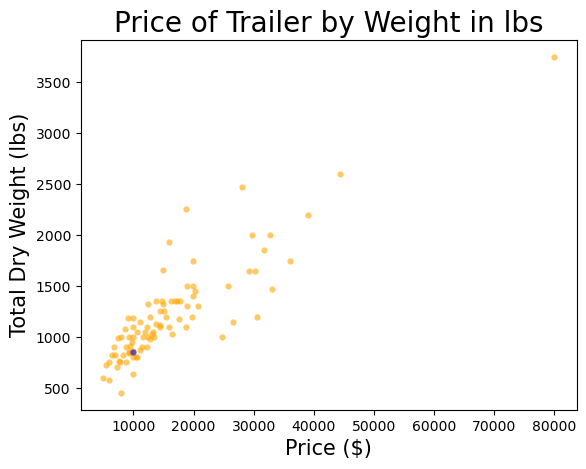

In [15]:
# values of x
x=data['price']
y= data['tdweight']

col = []
  
for i in range(0, len(x)):
    #the target trailer in blue
    if x[i]==9995:
        col.append('blue')  
    #all other trailers in orange
    else:
        col.append('orange') 
  
for i in range(len(x)):
      
    # plotting the corresponding x with y 
    # and respective color
    plt.scatter(x[i], y[i], c = col[i], s = 20,
                linewidth = 0, alpha=0.6)
    plt.title("Price of Trailer by Weight in lbs", fontsize=20)
    plt.ylabel("Total Dry Weight (lbs)", fontsize=15)
    plt.xlabel("Price ($)", fontsize=15)
      
plt.show()

Now let's look at how a few features map onto the weight vs. price

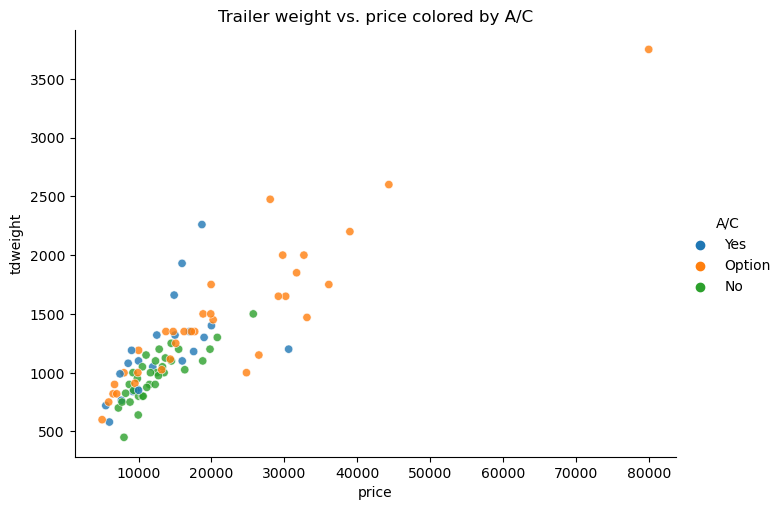

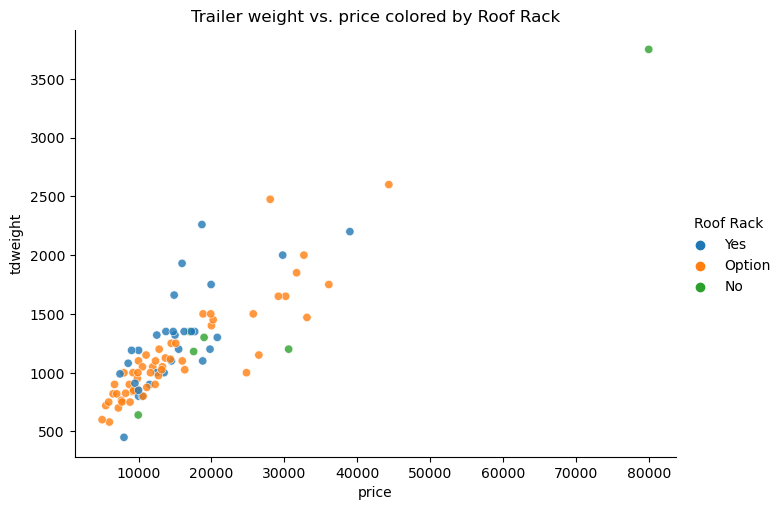

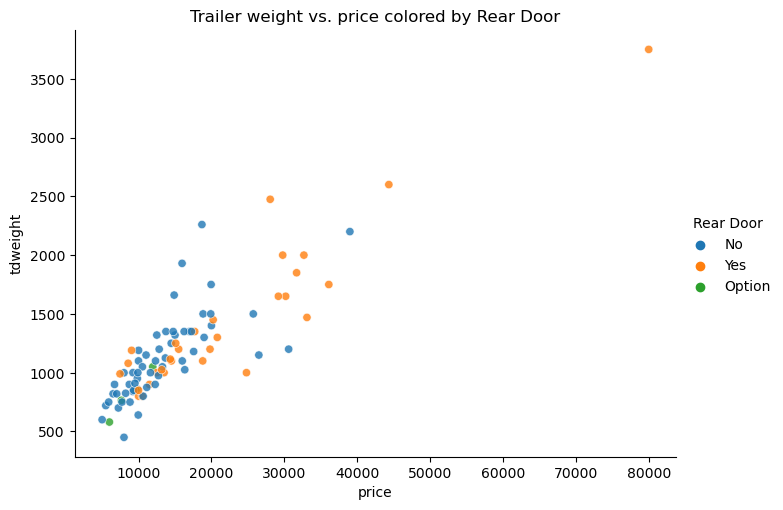

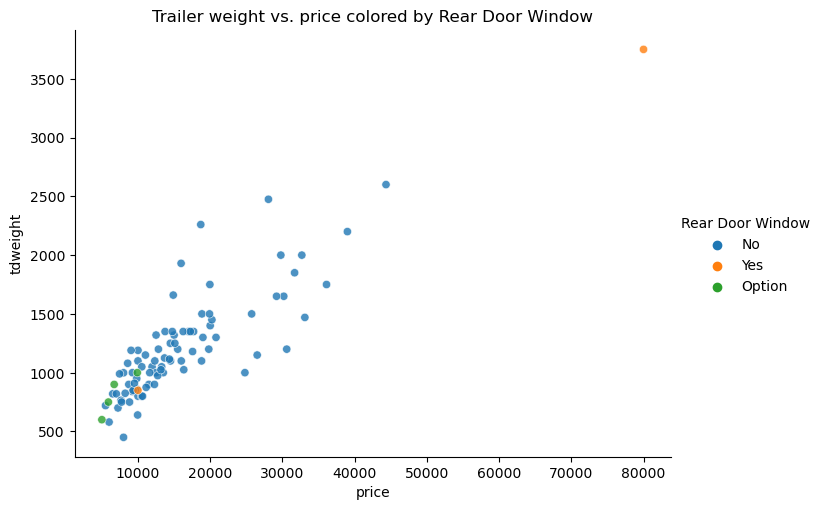

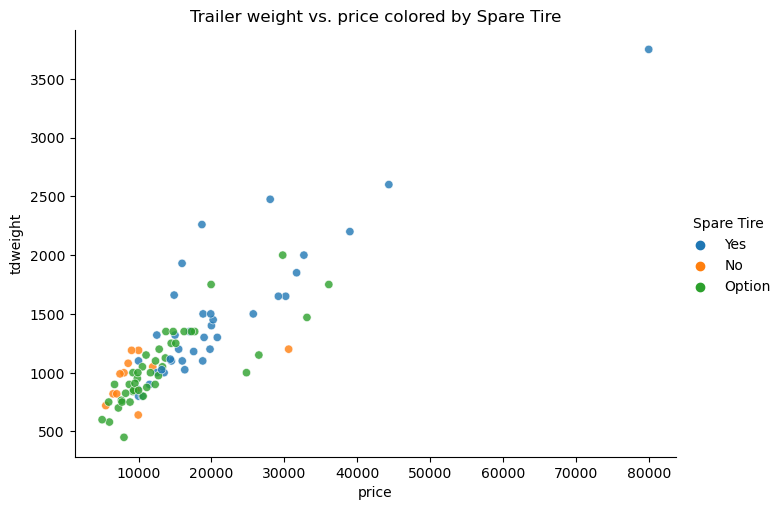

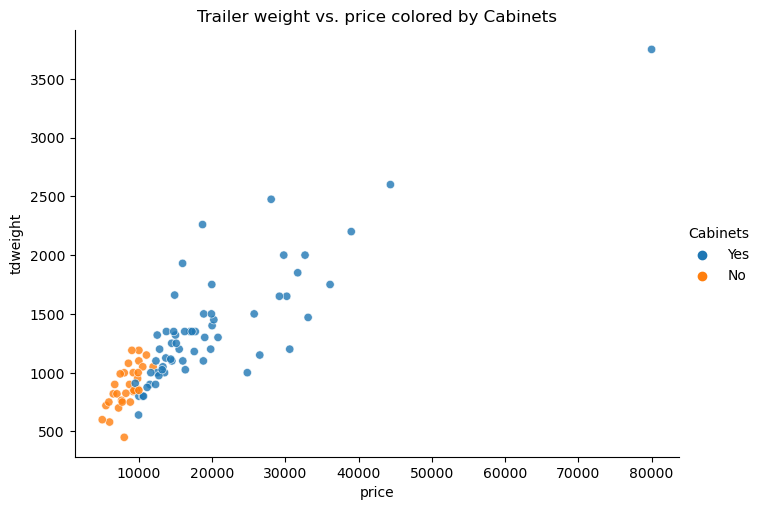

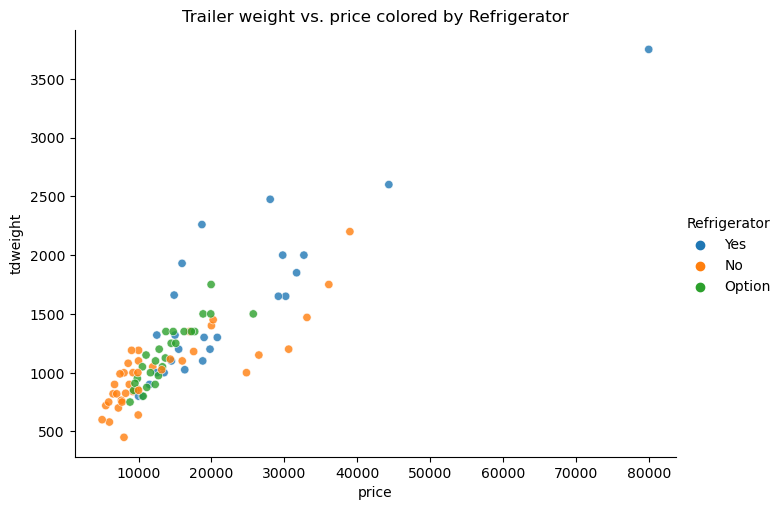

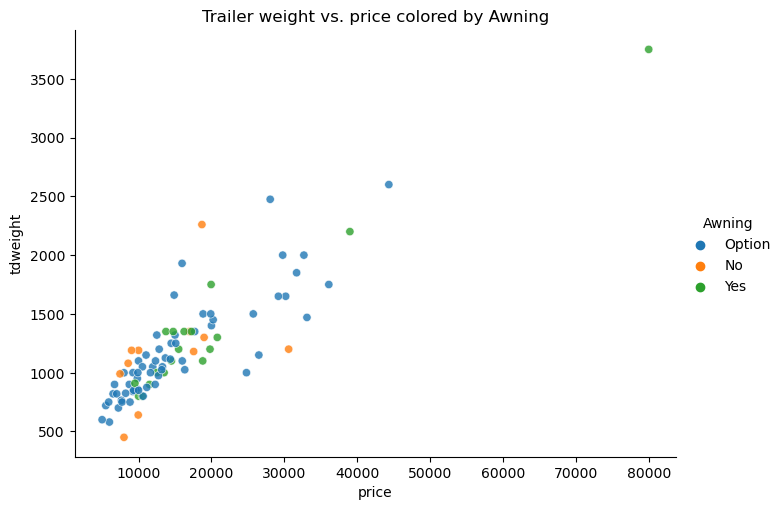

In [16]:
for c in ['A/C', 'Roof Rack', 'Rear Door', 'Rear Door Window', 'Spare Tire', 'Cabinets', 'Refrigerator', 'Awning']:
    sns.relplot(data=data, x='price', y='tdweight', hue=f"{c}", aspect=1.4, alpha=0.8)
    plt.title(f'Trailer weight vs. price colored by {c.title()}')
    plt.show()

In [17]:
#select the categorical data for encoding
cat_data = data.iloc[:, 5:24]
cat_data

,eheight,intheight,Usage Intent- On or Off Road,A/C,Roof Rack,Driver Side Window,Driver Side Door,Driver Side Door Window,Passenger Side Door,Passenger Side Door Window,Passenger Side Window,Rear Door,Rear Door Window,Wall Material,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning
0,84.0,54.0,On Road,Yes,Yes,Yes,No,No,Yes,Yes,Yes,No,No,Wood,Yes,Yes,Yes,Yes,Option
1,90.0,54.0,On Road,Yes,Yes,Yes,No,No,Yes,Yes,Yes,No,No,Wood,Yes,Yes,Yes,Yes,Option
2,90.0,54.0,On Road,Yes,Yes,Yes,No,No,Yes,Yes,Yes,No,No,Wood,Yes,Yes,Yes,Yes,Option
3,105.0,73.0,On Road,Yes,Yes,Yes,No,No,Yes,Yes,Yes,No,No,Wood,Yes,Yes,Yes,Yes,Option
4,108.0,74.0,On Road,Yes,Yes,Yes,No,No,Yes,Yes,Yes,No,No,Wood,Yes,Yes,Yes,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,67.5,45.0,On Road,Option,Option,Option,Option,Base,Base,Base,Base,No,Option,Wood,Option,No,No,No,Option
87,67.5,45.0,On Road,Option,Option,Option,Option,Base,Base,Base,Base,No,Option,Wood,Option,No,No,No,Option
88,67.5,45.0,On Road,Option,Option,Option,Option,Base,Base,Base,Base,No,Option,Wood,Option,No,No,No,Option
89,74.0,45.0,Off Road,Option,Option,Option,Option,Base,Base,Base,Base,No,Option,Wood,Option,No,No,No,Option


In [18]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()

#label encode the data to prepare for modeling
#label encoding is preferred for categorical variables

for col in cat_data:
    data[col] = labelencoder.fit_transform(data[col])
 
data.head()

,Manufacturer,model,tdweight,length,Cabin exterior width,eheight,intheight,Usage Intent- On or Off Road,A/C,Roof Rack,...,Passenger Side Window,Rear Door,Rear Door Window,Wall Material,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,price
0,Sunset Park RV,Sunray 109E,1660,198.0,102.0,25,10,1,2,2,...,2,0,0,7,2,2,1,2,1,14879
1,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,29,10,1,2,2,...,2,0,0,7,2,2,1,2,1,12500
2,Sunset Park RV,Sunray Classic 109,1320,144.0,102.0,29,10,1,2,2,...,2,0,0,7,2,2,1,2,1,14997
3,Sunset Park RV,Sunray Classic 129,1930,185.0,102.0,32,17,1,2,2,...,2,0,0,7,2,2,1,2,1,15965
4,Sunset Park RV,Classic 149,2260,188.0,102.0,33,18,1,2,2,...,2,0,0,7,2,2,1,2,0,18689


In [19]:
#make a copy of the data for later
data2=data

In [20]:
corr=data2.corr()
corr

,tdweight,length,Cabin exterior width,eheight,intheight,Usage Intent- On or Off Road,A/C,Roof Rack,Driver Side Window,Driver Side Door,...,Passenger Side Window,Rear Door,Rear Door Window,Wall Material,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,price
tdweight,1.000000,0.479780,0.428081,0.337758,0.526772,-0.173167,0.220696,-0.006932,0.107641,-0.055751,...,0.175329,0.280818,0.176753,-0.383475,0.418139,0.524364,0.479016,0.444427,0.124915,0.874837
length,0.479780,1.000000,0.506021,0.529647,0.232272,0.015037,-0.082191,0.026636,0.036919,0.221645,...,0.165271,0.151255,-0.132550,0.114820,0.341677,0.418452,0.460799,0.439231,0.194996,0.289591
Cabin exterior width,0.428081,0.506021,1.000000,0.601313,0.249283,0.216466,0.083419,0.173582,0.034099,-0.067275,...,0.261639,0.177382,-0.028555,-0.121556,0.422954,0.374308,0.443198,0.506004,0.181712,0.321240
eheight,0.337758,0.529647,0.601313,1.000000,0.476568,-0.041614,0.068026,0.163228,0.186708,-0.153682,...,0.260682,0.234252,-0.132178,0.112109,0.347582,0.279910,0.227946,0.319370,-0.065246,0.154581
intheight,0.526772,0.232272,0.249283,0.476568,1.000000,0.011195,0.528575,-0.094056,0.367261,-0.246825,...,0.309746,0.217643,0.119060,-0.344801,0.113132,-0.054720,-0.036785,0.033278,-0.360981,0.352110
Usage Intent- On or Off Road,-0.173167,0.015037,0.216466,-0.041614,0.011195,1.000000,0.182720,-0.139604,0.020340,-0.237599,...,-0.063962,-0.228163,0.155268,-0.204965,0.045943,-0.168181,-0.270438,-0.036024,-0.136948,-0.203222
A/C,0.220696,-0.082191,0.083419,0.068026,0.528575,0.182720,1.000000,-0.038850,0.199008,-0.545270,...,0.086113,0.017317,0.125923,-0.418450,-0.091878,-0.129724,-0.102125,-0.273980,-0.378632,0.090527
Roof Rack,-0.006932,0.026636,0.173582,0.163228,-0.094056,-0.139604,-0.038850,1.000000,-0.300199,0.001845,...,-0.053430,0.271031,-0.115245,0.338246,0.096350,0.316102,0.088354,0.342983,0.452650,-0.188690
Driver Side Window,0.107641,0.036919,0.034099,0.186708,0.367261,0.020340,0.199008,-0.300199,1.000000,-0.238710,...,0.675199,-0.072808,-0.083254,-0.258752,-0.047151,-0.134011,-0.087037,0.120087,-0.408131,-0.010793
Driver Side Door,-0.055751,0.221645,-0.067275,-0.153682,-0.246825,-0.237599,-0.545270,0.001845,-0.238710,1.000000,...,-0.067461,0.110788,-0.322848,0.107053,-0.150147,0.030796,0.135564,0.175031,0.177031,0.038113


<AxesSubplot:>

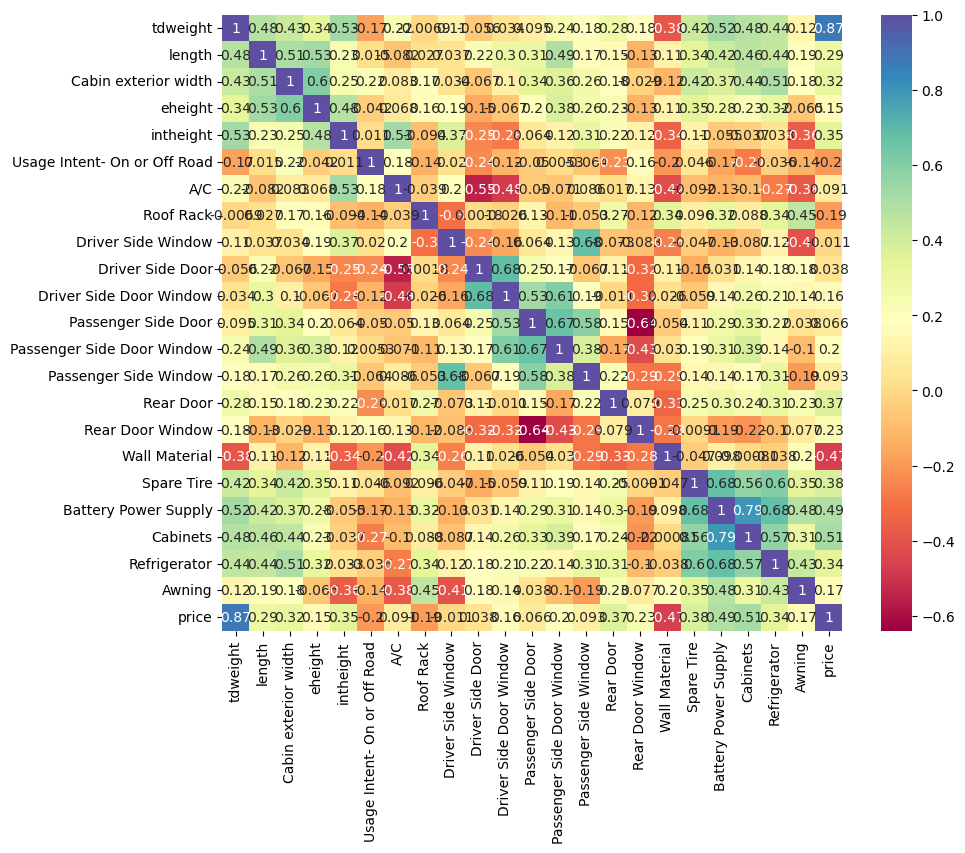

In [21]:
plt.figure(figsize=(10,8))
sns.heatmap(corr,annot=True,cmap="Spectral")

# Machine Learning Modeling
The data is now clean and we can move forward with creating some machine learning models. Once we settle on the best model it can be used to predict the target price of the trailer in question.

#Replace "option" with "no" and try modeling again

In [22]:
data2=data2.drop(data.index[[88]])

In [23]:
#here the data is split up into X,y where X contains everything but price and y contains what we want to predict (price)
#price is what we want to predict
X = data2.drop(['price', 'Manufacturer', 'model'],axis=1)
y=data2['price']

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [25]:
#scaling the data
#this usually helps with modeling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
#function which runs different ML models and prints R^2, MAE and RMSE
def run_experiment(model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
    #EVALUATION OF THE MODEL
    # Plotting y_test and y_pred to understand the spread.
    fig = plt.figure()
    plt.scatter(y_test,y_pred)
    fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
    plt.xlabel('y_test', fontsize=18)                          # X-label
    plt.ylabel('y_pred', fontsize=16) 

Now the data is all cleaned up and ready for creating some machine learning models. A funtion has been written to run various models and output metrics 

R^2 :  0.5999227518125122
MAE : 3424.8702390408057
RMSE: 5599.522936354599


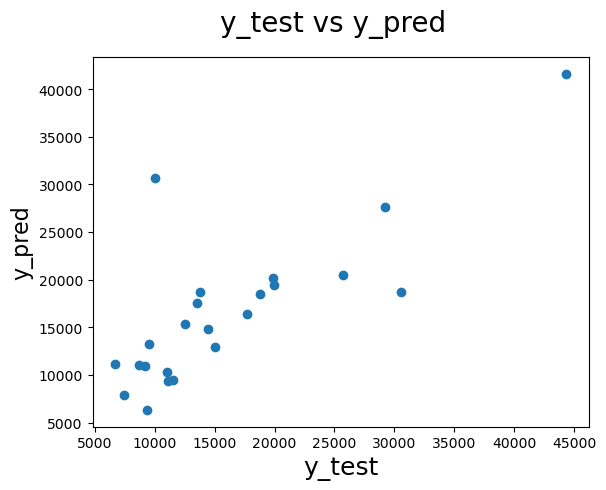

In [27]:
model_1 = LinearRegression()
run_experiment(model_1)

R^2 :  0.5921095144767788
MAE : 3213.2608695652175
RMSE: 5653.936001083477


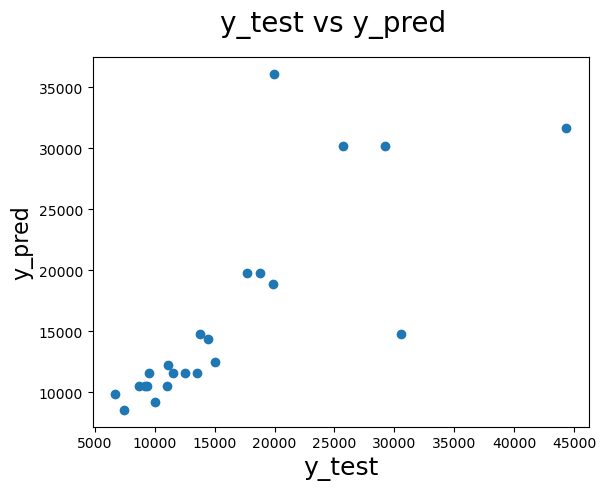

In [28]:
model_2 = DecisionTreeRegressor(random_state = 1)
run_experiment(model_2)

R^2 :  0.4906307672799818
MAE : 4481.920562588058
RMSE: 6318.230346865118


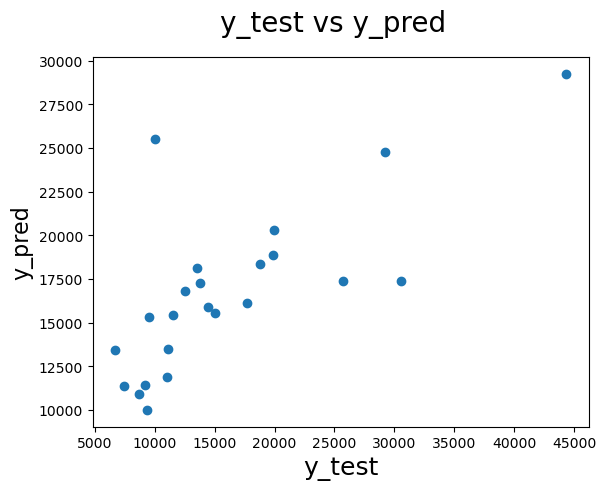

In [29]:
model_3 = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=1)
run_experiment(model_3)

R^2 :  -0.018007893719814927
MAE : 4940.237157064891
RMSE: 8932.122559892376


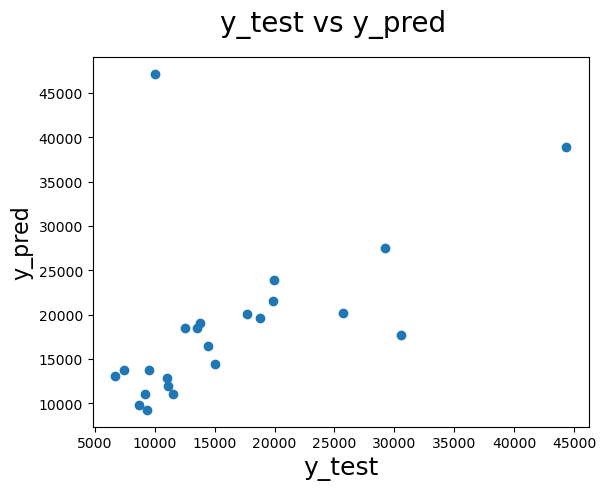

In [30]:
model_4 = Lasso(alpha=0.1, precompute=True, positive=True, selection='random', random_state=1)
run_experiment(model_4)

R^2 :  0.5660467805284248
MAE : 3537.3378799085244
RMSE: 5831.772291269675


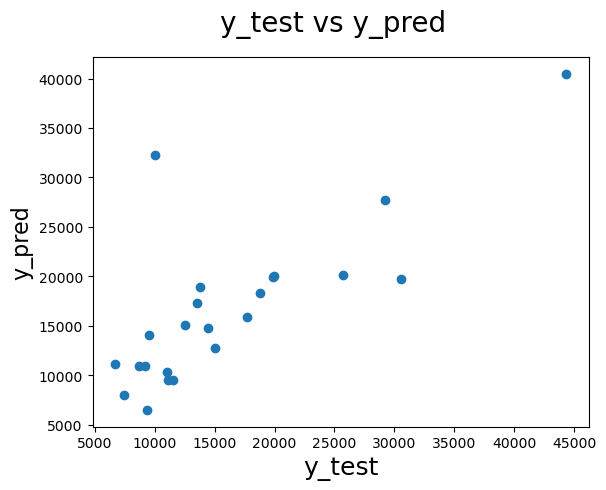

In [31]:
model_5 = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=1)
run_experiment(model_5)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


R^2 :  0.6002335241770529
MAE : 3423.711546960534
RMSE: 5597.347712624069


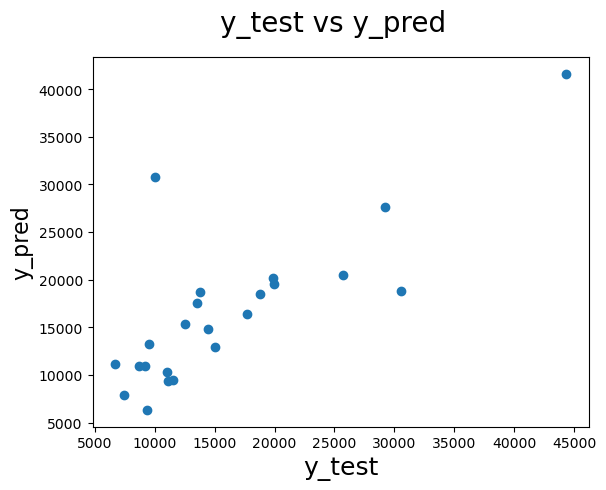

In [32]:
model_6 = LassoLars(alpha=.1)
run_experiment(model_6)

R^2 :  0.5273055966173006
MAE : 3683.1577900987213
RMSE: 6086.523888745756


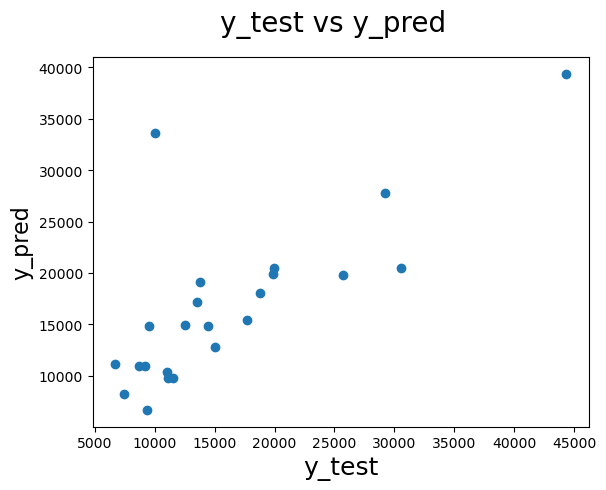

In [33]:
model_7 = BayesianRidge()
run_experiment(model_7)

R^2 :  0.5629336672340038
MAE : 3563.5361923146324
RMSE: 5852.653025728846


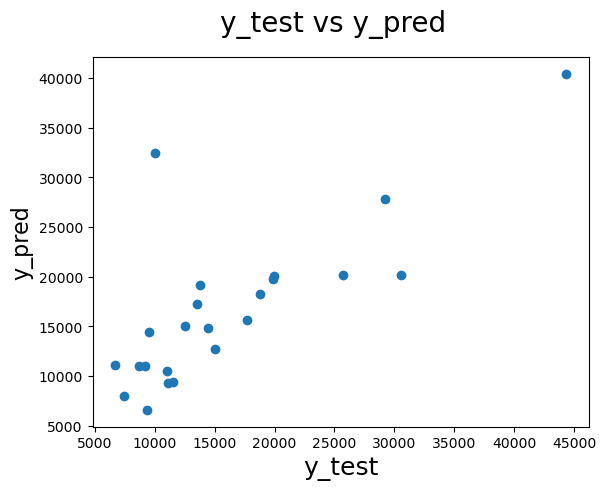

In [34]:
model_8 = SGDRegressor(max_iter=1000, tol=1e-3)
run_experiment(model_8)

R^2 :  -0.10785864861725569
MAE : 6200.5485234104235
RMSE: 9317.969336140644


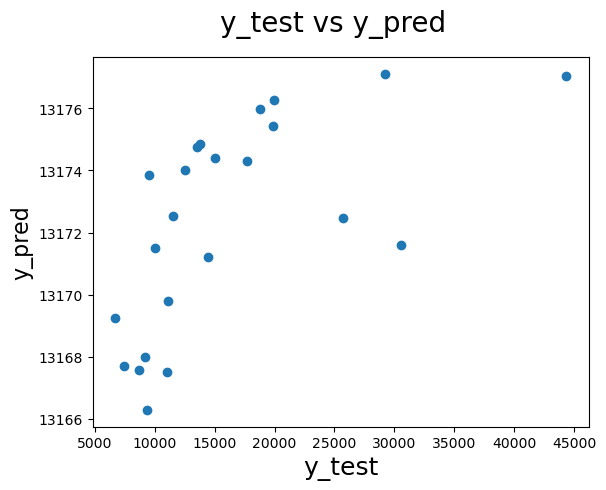

In [35]:
model_9 = SVR(epsilon=0.2)
run_experiment(model_9)

R^2 :  0.7383290970421892
MAE : 2955.3543198480265
RMSE: 4528.525496398439


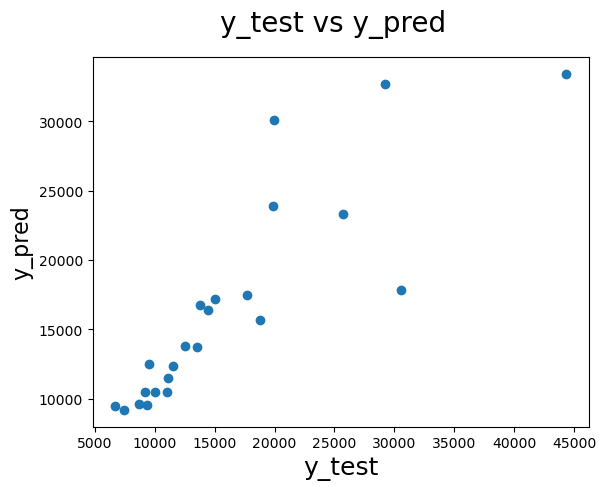

In [36]:
model_10 = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, random_state=1)
run_experiment(model_10)

Unsurprisingly, RandomForest preformed better than all the other models tested. Therefore we will move forward with tuning hyperparameters to figure out which produce the best result.

# Checking Feature Importance

The features which have been included thus far are based on features that have enough data available online to realistically include, and picking out which ones are actually important is still in progress. Currently, a more novel feature information (e.g. solar panels) are being mined, while others whihc are already included need to be optimized. One feature which is currently in process of engineering is the number of doors and if they include windows. the information is currently held in 4 seperate columns which have low correlation to the price, and should be combined into a single column containing all of the information to improve calculations. 

In [37]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = data2.drop(['price', 'Manufacturer', 'model'],axis=1)
y=data2['price']
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
#naming the columns
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(20,'Score'))  

                           Specs         Score
0                       tdweight  17818.207554
3                        eheight    356.557185
1                         length    278.345767
4                      intheight    229.232394
2           Cabin exterior width    220.976627
15              Rear Door Window    134.428571
14                     Rear Door    107.562500
20                  Refrigerator     69.103896
6                            A/C     63.844156
8             Driver Side Window     57.423729
16                 Wall Material     55.424528
18          Battery Power Supply     53.622642
5   Usage Intent- On or Off Road     48.562500
9               Driver Side Door     37.762590
10       Driver Side Door Window     35.820388
17                    Spare Tire     31.347826
19                      Cabinets     29.250000
12    Passenger Side Door Window     25.223684
21                        Awning     24.546392
7                      Roof Rack     23.368421


[0.18663587 0.13890341 0.11960912 0.10164691 0.0473274  0.04775445
 0.02651582 0.03160722 0.02250611 0.02380965 0.02361352 0.0086088
 0.02031487 0.02130938 0.02319829 0.00754083 0.02603082 0.02726166
 0.02362912 0.02129242 0.02786611 0.02301822]


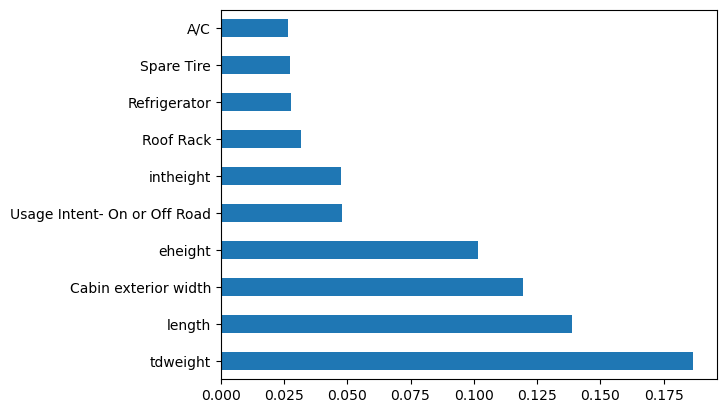

In [38]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

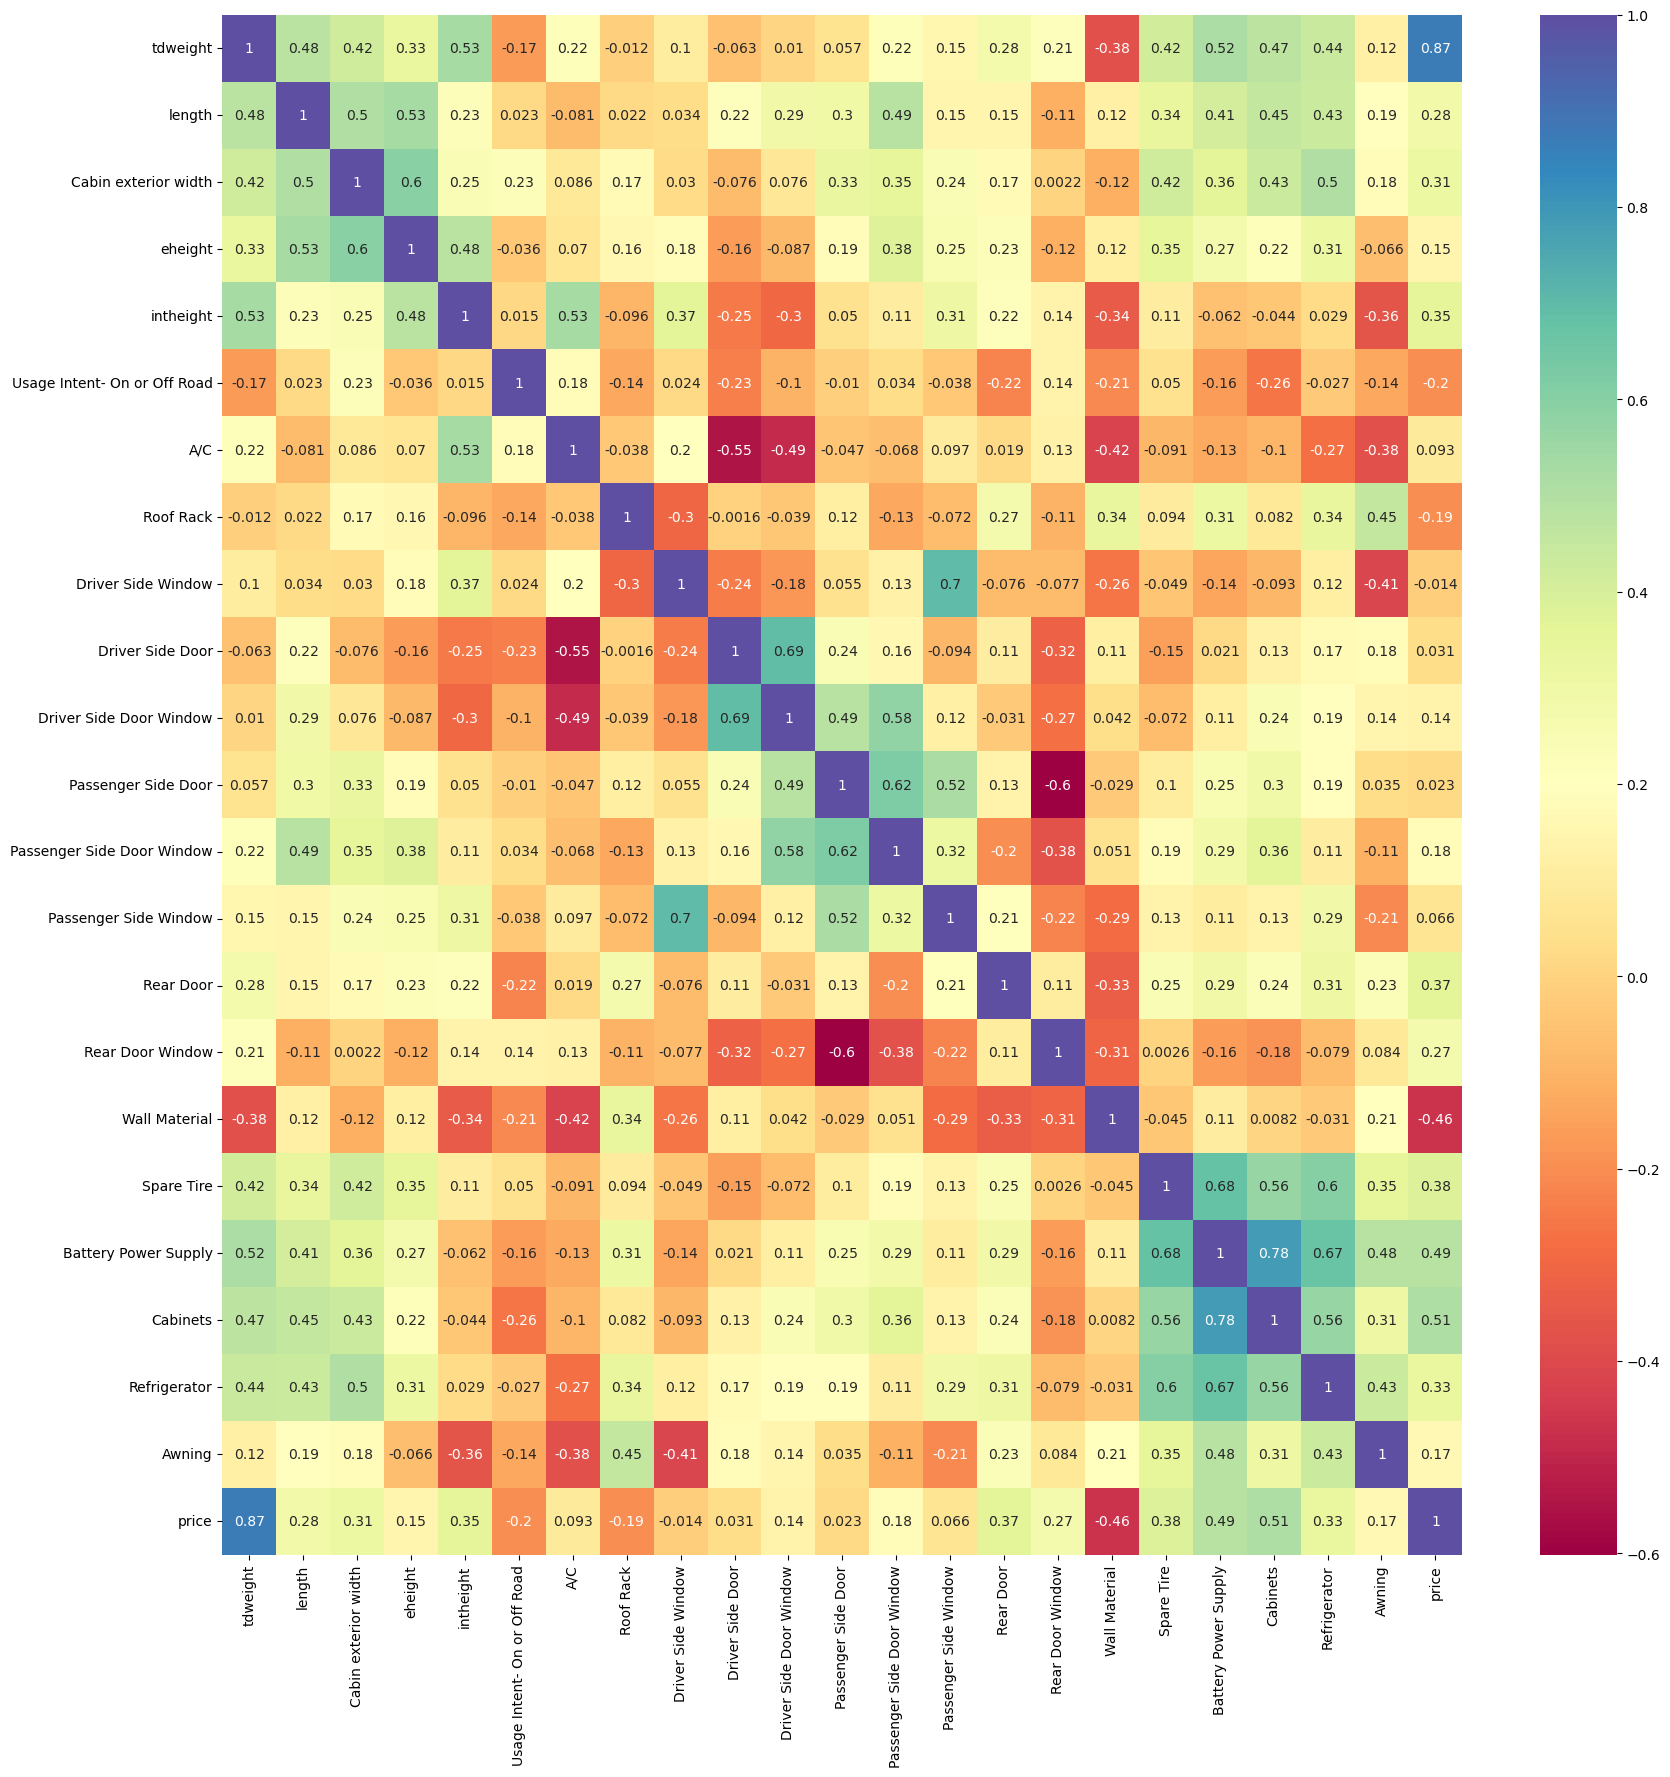

In [39]:
#get correlations of each features in dataset
corrmat = data2.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data2[top_corr_features].corr(),annot=True,cmap="Spectral")

# Feature Engineering
This section is in progress while more feature data is collected.

In [40]:
data3=data.drop(data.index[[90]])

In [41]:
#removing everything with a negative correlation
X = data3.drop(['price', 'Roof Rack', 'Driver Side Window', 'Driver Side Door', 'Passenger Side Door', 'Passenger Side Window', 'Manufacturer', 'model'],axis=1)
y=data3['price']

In [42]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [43]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
def run_experiment(model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
    #EVALUATION OF THE MODEL
    # Plotting y_test and y_pred to understand the spread.
    fig = plt.figure()
    plt.scatter(y_test,y_pred)
    fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
    plt.xlabel('y_test', fontsize=18)                          # X-label
    plt.ylabel('y_pred', fontsize=16) 

R^2 :  0.768930750984305
MAE : 2948.432081464285
RMSE: 4256.871935875946


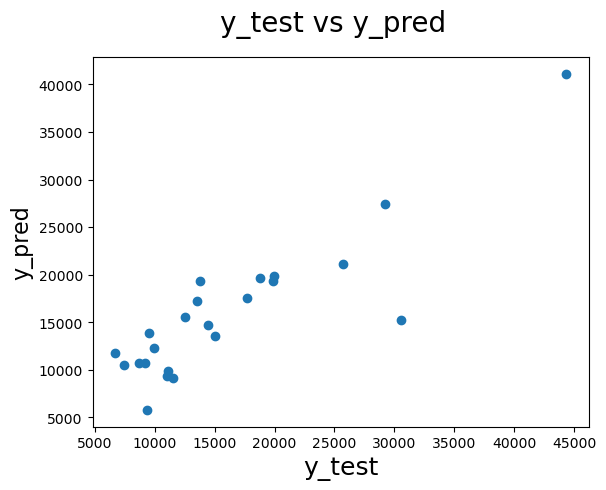

In [45]:
model_1 = LinearRegression()
run_experiment(model_1)

R^2 :  0.48366141312304023
MAE : 3615.0
RMSE: 6363.364481289685


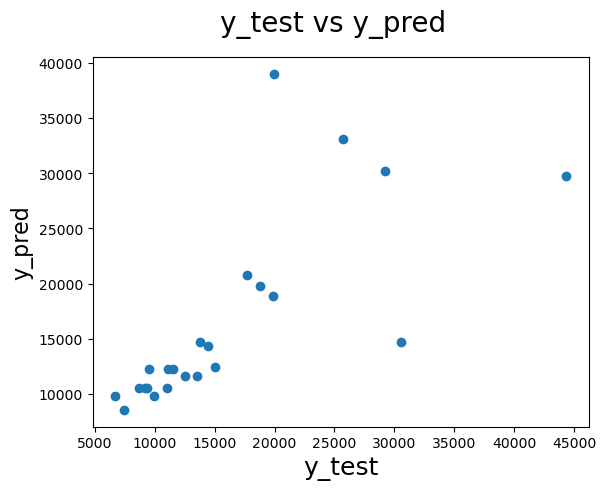

In [46]:
model_2 = DecisionTreeRegressor(random_state = 1)
run_experiment(model_2)

R^2 :  0.5793618070293323
MAE : 4072.00729586039
RMSE: 5743.463429499563


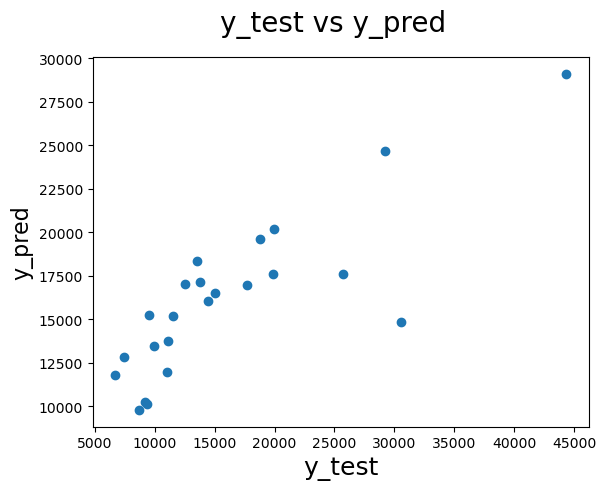

In [47]:
model_3 = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=1)
run_experiment(model_3)

R^2 :  0.7300019841575052
MAE : 3567.1692138164276
RMSE: 4601.503904777191


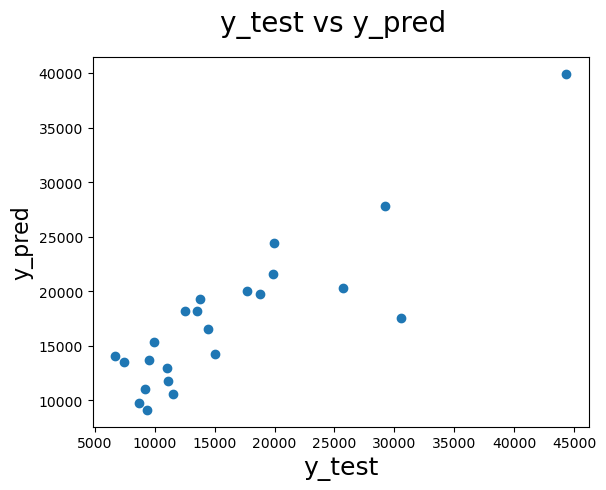

In [48]:
model_4 = Lasso(alpha=0.1, precompute=True, positive=True, selection='random', random_state=1)
run_experiment(model_4)

R^2 :  0.7746529282413259
MAE : 2981.6896507223923
RMSE: 4203.8331262863585


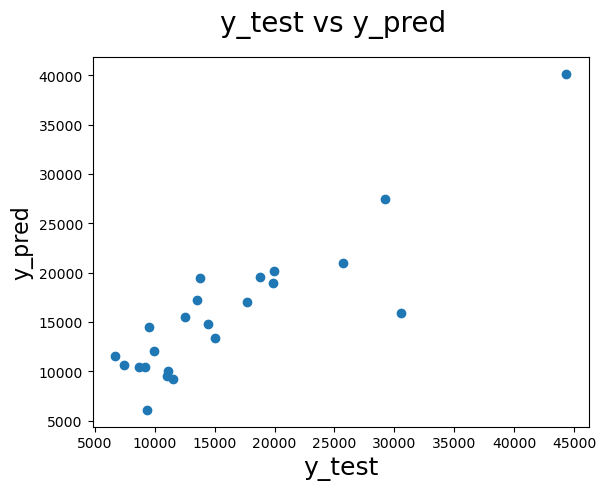

In [49]:
model_5 = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=1)
run_experiment(model_5)

R^2 :  0.7760031045101643
MAE : 3009.6632564567876
RMSE: 4191.220485888832


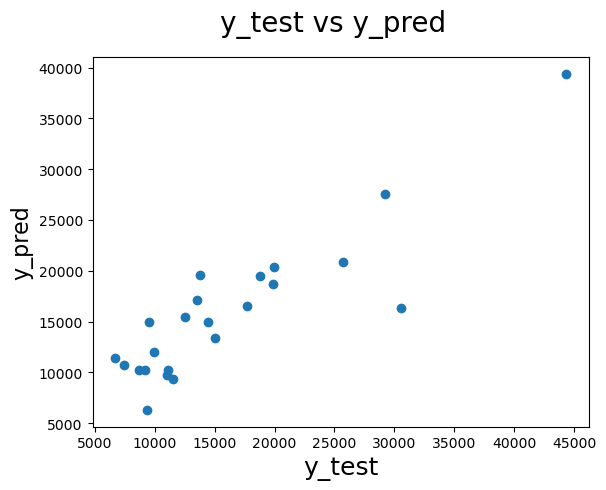

In [50]:
model_7 = BayesianRidge()
run_experiment(model_7)

R^2 :  0.7797842912464
MAE : 3012.4773687604643
RMSE: 4155.694909619963


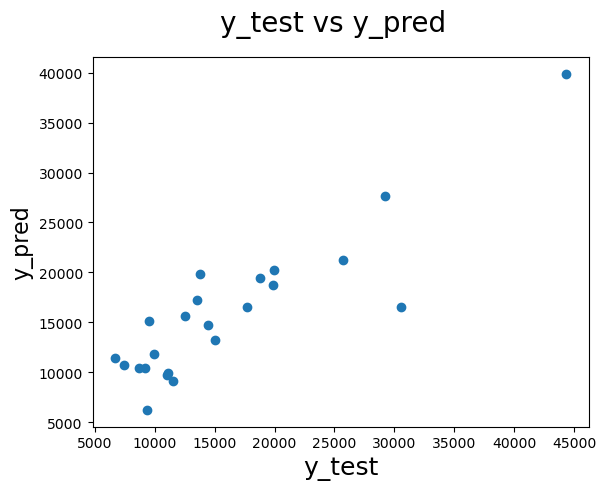

In [51]:
model_8 = SGDRegressor(max_iter=1000, tol=1e-3)
run_experiment(model_8)

R^2 :  -0.10748672012613847
MAE : 6204.027391690493
RMSE: 9319.417588677967


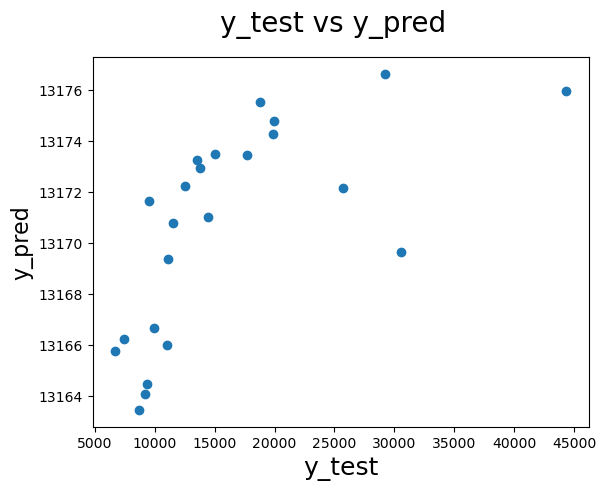

In [52]:
model_9 = SVR(epsilon=0.2)
run_experiment(model_9)

R^2 :  0.7449019636567538
MAE : 2800.8594718602653
RMSE: 4472.733954206414


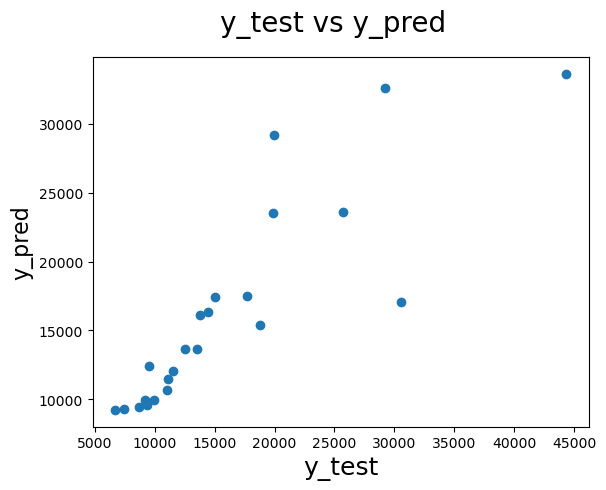

In [53]:
model_10 = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, random_state=1)
run_experiment(model_10)

[0.20683561 0.1397027  0.13676628 0.10349653 0.05190441 0.05031483
 0.03583964 0.02938034 0.02466243 0.02517165 0.00748393 0.02868023
 0.03303423 0.03362134 0.0204362  0.03659232 0.03607735]


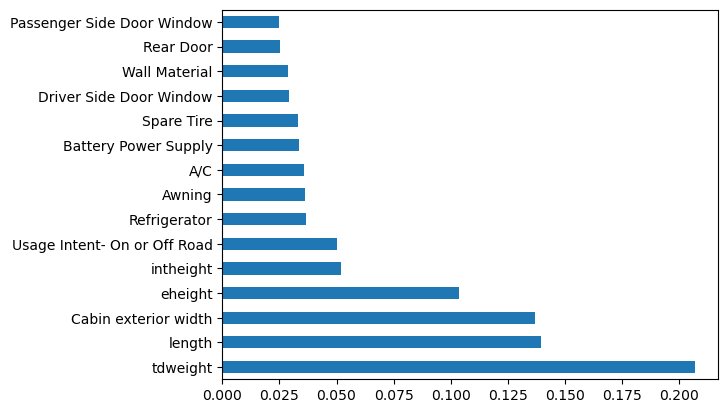

In [54]:
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances 
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

## Hyperparameter Tuning
Perhaps it is a bit early to get into hyperparameter tuning, but nonetheless the code is ready for once the dataset has been expanded :) Commented out for time saving purposes.

In [55]:
rfc=RandomForestRegressor(random_state=1)

In [56]:
param_grid = { 
    'n_estimators': [100, 500, 1000, 5000],
    'max_features': ['auto', 'sqrt', 'log2'],
    #to save time in updating the notebook, max_depth is also left out
     'max_depth' : [5, 10, 15],
    # 'min_samples_leaf' : [1,2,3,5],
     #'criterion' :['squared_error', 'absolute_error', 'friedman_mse']
}


In [57]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
CV_rfc.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=1),
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 500, 1000, 5000]})

In [58]:
#print the best parameters determined in GridSearchCV
CV_rfc.best_params_

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 500}

R^2 :  0.7034868840774744
MAE : 2910.2184534161493
RMSE: 4822.158297518314


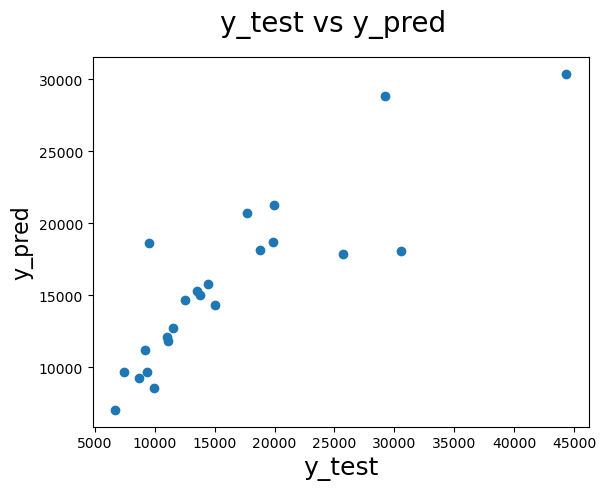

In [59]:
#run a final model using the optimal parameters
final_model = RandomForestRegressor(criterion= 'squared_error', n_estimators=100, max_features='sqrt', max_depth=10, min_samples_leaf=1, random_state=1)
run_experiment(final_model)

# Checking the value of interest

In [60]:
new_input = data.loc[90:91]
new_input

,Manufacturer,model,tdweight,length,Cabin exterior width,eheight,intheight,Usage Intent- On or Off Road,A/C,Roof Rack,...,Passenger Side Window,Rear Door,Rear Door Window,Wall Material,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning,price
90,XYZ Camping,NaN,850,144.0,93.0,16,8,2,2,2,...,2,2,2,1,1,0,0,0,1,9995


In [61]:
#drop the variable to be predicted
new_input=new_input.drop(['price', 'Roof Rack', 'Driver Side Window', 'Driver Side Door', 'Passenger Side Door', 'Passenger Side Window', 'Manufacturer', 'model'],axis=1)
new_input

,tdweight,length,Cabin exterior width,eheight,intheight,Usage Intent- On or Off Road,A/C,Driver Side Door Window,Passenger Side Door Window,Rear Door,Rear Door Window,Wall Material,Spare Tire,Battery Power Supply,Cabinets,Refrigerator,Awning
90,850,144.0,93.0,16,8,2,2,3,3,2,2,1,1,0,0,0,1


In [62]:
new_input_scaled = scaler.fit_transform(new_input)

In [63]:
new_output = final_model.predict(new_input_scaled)
new_output

array([18440.175])

# Notes on the metrics used
✔️ Regression Evaluation Metrics
Here are three common evaluation metrics for regression problems:

Mean Absolute Error (MAE) is the mean of the absolute value of the errors:
1𝑛∑𝑖=1𝑛|𝑦𝑖−𝑦̂𝑖|
1
n
∑
i
=
1
n
|
y
i
−
y
^
i
|
 

 
Mean Squared Error (MSE) is the mean of the squared errors:
1𝑛∑𝑖=1𝑛(𝑦𝑖−𝑦̂𝑖)2
1
n
∑
i
=
1
n
(
y
i
−
y
^
i
)
2
 
Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors:
1𝑛∑𝑖=1𝑛(𝑦𝑖−𝑦̂𝑖)2‾‾‾‾‾‾‾‾‾‾‾‾‾‾⎷
1
n
∑
i
=
1
n
(
y
i
−
y
^
i
)
2
 
📌 Comparing these metrics:

MAE is the easiest to understand, because it's the average error.
MSE is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units.
All of these are loss functions, because we want to minimize them.

https://www.kaggle.com/code/faressayah/practical-introduction-to-10-regression-algorithm?scriptVersionId=117768677&cellId=36

<iframe src="https://www.kaggle.com/embed/faressayah/practical-introduction-to-10-regression-algorithm?cellIds=36&kernelSessionId=117768677" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="Practical Introduction to 10 Regression Algorithm"></iframe>